In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import glob

matplotlib.rc('font', family='Times')
matplotlib.rcParams.update({'font.size': 14})

In [2]:
class Message(object):
    def __init__(self, msg_id, orig_msg_id, who_posted, who_originated, content):
        self.msg_id = msg_id
        self.orig_msg_id = orig_msg_id
        self.who_posted = who_posted
        self.who_originated = who_originated
        self.content = content

    def to_dict(self):
        return {'msg_id': self.msg_id, 'orig_msg_id':self.orig_msg_id,
                'who_posted':self.who_posted, 'who_originated':self.who_originated,
                'content':self.content,}

In [3]:
class Agent(object):
    def __init__(self, user_id, epsilon):
        self.user_id = user_id
        self.opinion = np.random.uniform(-1.0, 1.0)
        self.epsilon = epsilon
        self.orig_msg_ids_in_screen = []


    def set_orig_msg_ids_in_screen(self, screen):
        self.orig_msg_ids_in_screen = screen.orig_msg_id.values


    def evaluate_messages(self, screen):
        self.concordant_msgs = []
        self.discordant_msgs = []
        if len(screen) > 0:
            self.concordant_msgs = screen[abs(self.opinion - screen.content) < self.epsilon]
            self.discordant_msgs = screen[abs(self.opinion - screen.content) >= self.epsilon]


    def update_opinion(self, mu):
        if len(self.concordant_msgs) > 0:
            self.opinion = self.opinion + mu * np.mean(self.concordant_msgs.content - self.opinion)

    
    def post_message(self, msg_id, p):
        if len(self.concordant_msgs) > 0 and np.random.random() < p:
            # repost a friend's message selected at random
            idx = np.random.choice(self.concordant_msgs.index)
            selected_msg = self.concordant_msgs.loc[idx]
            return Message(msg_id=int(msg_id), 
                           orig_msg_id=int(selected_msg.orig_msg_id),
                           who_posted=int(self.user_id), 
                           who_originated=int(selected_msg.who_originated),
                           content=selected_msg.content)
        else:
            # post a new message
            new_content = self.opinion
            return Message(msg_id=int(msg_id), orig_msg_id=int(msg_id),
                           who_posted=int(self.user_id), who_originated=int(self.user_id), content=new_content)

        
    def decide_follow_id_at_random(self, friends, num_agents):
        prohibit_list = list(friends) + [self.user_id]
        return int(np.random.choice([i for i in range(num_agents) if i not in prohibit_list]))

    
    def decide_unfollow_id_at_random(self, discordant_messages):
        unfollow_candidates = discordant_messages.who_posted.values
        return int(np.random.choice(unfollow_candidates))

    
    def decide_to_rewire(self, social_media, following_methods):
        unfollow_id = None
        follow_id = None

        if len(self.discordant_msgs) > 0:
            # decide whom to unfollow
            unfollow_id = self.decide_unfollow_id_at_random(self.discordant_msgs)
            # decide whom to follow
            following_method = np.random.choice(following_methods)
            friends = social_media.G.neighbors(self.user_id)
            friends = list(friends)

            # Repost-based selection if possible; otherwise random selection
            if following_method == 'Repost':
                friends_of_friends = list(set(self.concordant_msgs.who_originated.values) - set(friends))
                if len(friends_of_friends) > 0:
                    follow_id = int(np.random.choice(friends_of_friends))
                else:
                    follow_id = self.decide_follow_id_at_random(friends, social_media.G.number_of_nodes())

            # Recommendation-basd selection if possible; otherwise random selection
            elif following_method == 'Recommendation':
                similar_agents = social_media.recommend_similar_users(self.user_id, self.epsilon, social_media.G.number_of_nodes())
                if len(similar_agents) > 0:
                    follow_id = int(np.random.choice(similar_agents))
                else:
                    follow_id = self.decide_follow_id_at_random(friends, social_media.G.number_of_nodes())

            # Random selection
            else:
                follow_id = self.decide_follow_id_at_random(friends, social_media.G.number_of_nodes())

        return unfollow_id, follow_id

In [4]:
class SocialMedia(object):
    def __init__(self, num_agents, num_links, l, sns_seed):
        self.num_agents = num_agents
        random_state = np.random.RandomState(sns_seed)
        self.G = nx.gnm_random_graph(n=num_agents, m=num_links, seed=random_state, directed=True)
        self.modify_random_graph()
        self.message_dic = {}
        self.message_df = pd.DataFrame(columns=['msg_id', 'orig_msg_id', 'who_posted', 'who_originated', 'content'])
        self.screen_size = l


    def modify_random_graph(self):
        for no_outdegree_node in [k for k, v in list(self.G.out_degree()) if v == 0]:
            target_node = np.random.choice([k for k, v in list(self.G.out_degree()) if v >= 2])
            i = np.random.choice(len(self.G.edges(target_node)))
            target_edge = list(self.G.edges(target_node))[i]
            self.G.remove_edge(target_edge[0], target_edge[1])
            self.G.add_edge(no_outdegree_node, target_edge[1])


    def set_node_colors(self, node_colors):
        for i, c in enumerate(node_colors):
            self.G.nodes[i]['color'] = c


    def show_screen(self, user_id):
        friends = self.G.neighbors(user_id)
        friend_message_df = self.message_df[self.message_df['who_posted'].isin(friends)]
        friend_message_df = friend_message_df[friend_message_df['who_originated'] != user_id]
        return friend_message_df.tail(self.screen_size)


    def update_message_db(self, t, msg):
        self.message_df = pd.concat([self.message_df, pd.DataFrame([msg.to_dict()])])
        self.message_df.reset_index(drop=True, inplace=True)
        #self.message_df = self.message_df.append(msg.to_dict(), ignore_index=True).tail(self.num_agents)
        

    def recommend_similar_users(self, user_id, epsilon, num_agents):
        similar_users = []
        my_message_df = self.message_df[self.message_df.who_originated == user_id].tail(1)

        if len(my_message_df) > 0:
            last_message = my_message_df.content.values[0]
            friends = self.G.neighbors(user_id)
            friends = list(friends)
            similar_messages_df = self.message_df[self.message_df.who_originated != user_id].tail(num_agents)
            similar_messages_df = similar_messages_df[abs(last_message - similar_messages_df.content) < epsilon]
            if len(similar_messages_df) > 0:
                similar_users = [u for u in similar_messages_df.who_originated.values if u not in friends]

        return similar_users


    def rewire_users(self, user_id, unfollow_id, follow_id):
        self.G.remove_edge(user_id, unfollow_id)
        self.G.add_edge(user_id, follow_id)

In [5]:
class EchoChamberDynamics(object):
    def __init__(self, num_agents, num_links, epsilon, sns_seed, l):
        self.num_agents = num_agents
        self.l = l
        self.epsilon = epsilon
        self.set_agents(num_agents, epsilon)
        self.social_media = SocialMedia(num_agents, num_links, l, sns_seed)
        self.opinion_data = []


    def set_agents(self, num_agents, epsilon):
        self.agents = [Agent(i, epsilon) for i in range(num_agents)]

        
    def total_discordant_messages(self):
        total_discordant_msgs = 0
        for a in self.agents:
            total_discordant_msgs += len(a.discordant_msgs)
        return total_discordant_msgs
   
    
    def is_stationary_state(self, G):
        num_clusters = len([G.subgraph(c) for c in nx.weakly_connected_components(G)])
        num_converged_clusters = 0

        if num_clusters >= 2:
            for C in [G.subgraph(c) for c in nx.weakly_connected_components(G)]:
                _agents = [self.agents[i] for i in list(C.nodes())]
                opinions = np.array([a.opinion for a in _agents])
                opi_diff = np.max(opinions) - np.min(opinions)
                if opi_diff <= self.epsilon:
                    num_converged_clusters += 1

        if num_converged_clusters == num_clusters:
            return True
        else:
            return False

        
    def evolve(self, t_max, mu, p, q, rewiring_methods):
        for t in range(t_max):
            #print("t = ", t)
            self.opinion_data.append([a.opinion for a in self.agents])
            #self.screen_diversity_data.append([a.screen_diversity for a in self.agents])

            # export network data
            if t % 1000 == 0:
                print(t)

            # select agent i at random
            user_id = np.random.choice(self.num_agents)

            # agent i refleshes its screen and reading it
            screen = self.social_media.show_screen(user_id)
            self.agents[user_id].evaluate_messages(screen)

            # social influence (mu)
            unfollow_id = None
            follow_id = None
            self.agents[user_id].update_opinion(mu)

            # rewiring (q)
            if np.random.random() < q:
                unfollow_id, follow_id = self.agents[user_id].decide_to_rewire(self.social_media, rewiring_methods)
                if unfollow_id is not None and follow_id is not None:
                    self.social_media.rewire_users(user_id, unfollow_id, follow_id)

            # post (1-p) or repost (p) a message 
            msg = self.agents[user_id].post_message(t, p)
            self.social_media.update_message_db(t, msg)
       
            # finalize and export data            
            if self.is_stationary_state(self.social_media.G):
                break
            elif t >= t_max - 1:
                break

In [33]:
N = 100
E = 400
epsilon = .4
l = 10
sns_seed = np.random.randint(0, 100000)

ecd = EchoChamberDynamics(num_agents = N,
                          num_links = E,
                          epsilon = epsilon,
                          sns_seed = sns_seed,
                          l = l)

In [34]:
ecd.set_agents(num_agents=N,
               epsilon=.4)

In [15]:
ecd.social_media.show_screen(1)

,msg_id,orig_msg_id,who_posted,who_originated,content


In [35]:
t_max = 20000
mu = .5
p = .5
q = .5
rewiring_methods = ['Random']

ecd.evolve(t_max, mu, p, q, rewiring_methods)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


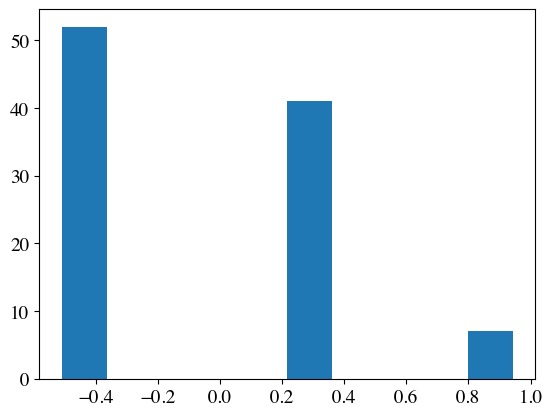

In [36]:
plt.hist([ecd.agents[i].opinion for i in range(100)], bins=10)
plt.show()

In [37]:
pd.read_csv('/Users/oseckin/Desktop/Research/Prosocial Reranking Challenge/annotation/joint/answer.csv')

,Unnamed: 0,id,response
0,0,y0ljxv,<s> [INST] Here are the definitions for two ca...
1,1,qj9jbx,<s> [INST] Here are the definitions for two ca...
2,2,qhpfuy,<s> [INST] Here are the definitions for two ca...
3,3,s0l4h4,<s> [INST] Here are the definitions for two ca...
4,4,vv0lhp,<s> [INST] Here are the definitions for two ca...
5,5,m963ak,<s> [INST] Here are the definitions for two ca...
6,6,p4x8u2,<s> [INST] Here are the definitions for two ca...
7,7,l0yh9f,<s> [INST] Here are the definitions for two ca...
8,8,p9e5ax,<s> [INST] Here are the definitions for two ca...
9,9,oc27pn,<s> [INST] Here are the definitions for two ca...
